In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
from string_to_binary_coder import encode_string
from TurboCoder import TurboCoder

In [31]:
fs = 1e3
frame_size = 36 # 32 samples + 4 samples turbo coder overhead
num_frames = 10
num_frames_sync = 1
num_syms_cntrl = 1

In [32]:
def zadoff_chu_sequence(length, root=25):
    n = np.arange(0, length)
    if length % 2 != 0:
        return np.exp(1j * np.pi * root * n * (n + 1) / length)
    return np.exp(1j * np.pi * root * n**2 / length)

def add_channel_impulse_response(x, fc, distances=None, fs=30.72e6):
    c0 = 3e8  # Lichtgeschwindigkeit in m/s
    lam = c0 / fc  # Wellenlänge in m

    if distances is None:
        distance1 = 5981.3 * (c0 / (4 * fc))  # 249.22 m
        distance2 = 3522 * (c0 / (4 * fc))  # 146.75 m
        distances = np.array([distance1, distance2])  # in m

    path_delays = distances / c0  # in s
    # Fris-Freespace-Modell
    amplitudes = np.sqrt(lam / (4 * np.pi * distances) ** 2)

    h = np.zeros(len(x), 'complex')

    t = np.arange(len(x)) # in Samples

    for amplitude, tau in zip(amplitudes, path_delays):
        tau_i = int(np.round(tau * fs)) # in Samples
        delta_i = amplitude * signal.gausspulse(t-tau_i)
        h  = h + delta_i

    # convolution, note: convolution in time domain is multiplication in frequency domain
    # the diskrete convolution via fft corresponds to a circular convolution
    return np.fft.ifft(np.fft.fft(x) * np.fft.fft(h)), h

def add_gaussian_noise(iq_samples, snr):
    """
    Adds Gaussian noise to the IQ samples.
    :param iq_samples:
    :param snr: in dB
    :return: IQ samples with noise, SNR in dB
    """
    iq_samples_power = np.sum(np.abs(iq_samples) ** 2) / len(iq_samples)
    noise_variance = iq_samples_power / (10 ** (snr / 10))
    noise = np.sqrt(noise_variance / 2) * (np.random.randn(len(iq_samples)) + 1j * np.random.randn(len(iq_samples)))
    iq_samples_with_noise = iq_samples + noise

    return iq_samples_with_noise

In [33]:
qam_symbol_alphabet = {
    "00": 1 + 1j,
    "01": -1 + 1j,
    "11": -1 - 1j,
    "10": 1 - 1j
}

In [34]:

# 1 Data Frame consists of 32 samples, each one carries a information symbol
# with QPSK modulation, 2 bits per symbol
# 1 Frame = 32 samples = 16 symbols = 32 bits
# with a code rate of 1/2, 16 information bits are encoded to 32 bits
# in ascii 1 symbol = 1 byte = 8 bits
information_str = "MASO"
information_bits = encode_string(information_str)
print(information_bits)
print(len(information_bits[0]))

[[0 1 0 0 1 1 0 1 0 1 0 0 0 0 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1]]
32


In [35]:
turbo_coder = TurboCoder(code_rate=1/2, constraint_length=4)
encoded_bits = turbo_coder.encode(information_bits)
print(encoded_bits)
print (len(encoded_bits))

[0 0 1 0 0 1 0 1 1 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 1 0
 1 1 0 0 1 0 0 1 1 1 0 0 1 1 0 0 1 0 0 1 0 1 1 1 0 1 0 1 0 1 0 1 1 1 1]
72


In [36]:
# map bits to symbols
data_frame = np.empty(frame_size, dtype=np.complex64)
bits_per_symbol = 2 # QPSK
l = 0
for i in range(0, frame_size):

    bits = f"{int(encoded_bits[l])}{(encoded_bits[l+1])}"
    data_frame[i] = qam_symbol_alphabet[bits]
    l = l + 2
print(data_frame)

[ 1.+1.j  1.-1.j -1.+1.j -1.+1.j  1.-1.j  1.-1.j  1.+1.j  1.-1.j  1.+1.j
 -1.-1.j  1.+1.j  1.+1.j  1.+1.j -1.+1.j -1.+1.j  1.-1.j -1.+1.j -1.-1.j
 -1.+1.j  1.-1.j -1.+1.j  1.+1.j -1.-1.j  1.-1.j -1.+1.j  1.-1.j -1.+1.j
  1.+1.j  1.-1.j -1.-1.j  1.-1.j  1.-1.j  1.-1.j  1.-1.j -1.-1.j -1.-1.j]


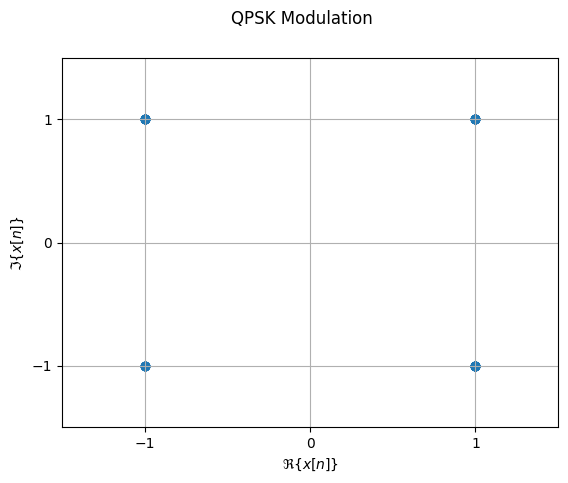

In [37]:
plt.scatter(np.real(data_frame), np.imag(data_frame))
plt.suptitle("QPSK Modulation")
plt.xlabel(r'$\Re\{x[n]\}$')
plt.ylabel(r'$\Im\{x[n]\}$')
plt.xticks([-1, 0,1])
plt.yticks([-1, 0,1])
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.grid(True)

Text(0, 0.5, '$\\Im\\{x[n]\\}$')

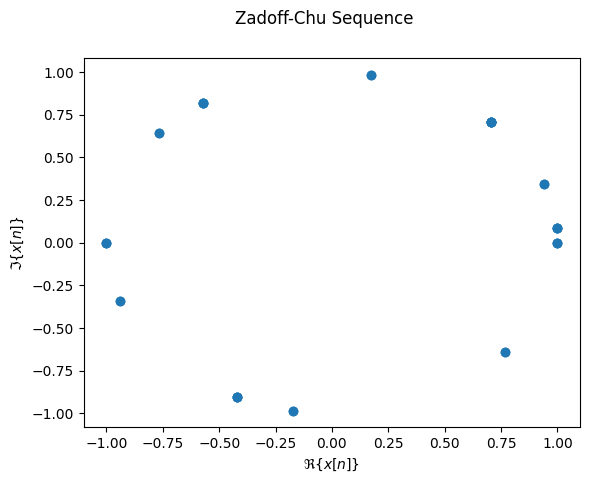

In [38]:
# create zadoff chu sequence with a length of frame size
synchronization_frame = zadoff_chu_sequence(frame_size, root=25)
plt.scatter(np.real(synchronization_frame), np.imag(synchronization_frame))
plt.suptitle("Zadoff-Chu Sequence")
plt.xlabel(r'$\Re\{x[n]\}$')
plt.ylabel(r'$\Im\{x[n]\}$')

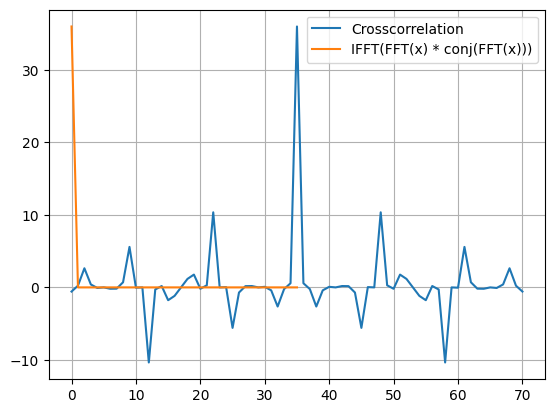

In [39]:
plt.plot(np.correlate(synchronization_frame, synchronization_frame, mode='full'))
plt.plot(np.fft.ifft(np.fft.fft(synchronization_frame) * np.conj(np.fft.fft(synchronization_frame))))
plt.legend(["Crosscorrelation", "IFFT(FFT(x) * conj(FFT(x)))"])
plt.grid(True)

In [40]:
# create a chunk of synchronization and data frame
frame = np.concatenate([synchronization_frame, data_frame])

In [41]:
# implement the maximum correlation with the known synchronization frame
known_sync_frame = zadoff_chu_sequence(frame_size, root=25)
correlation_result = np.zeros_like(frame, dtype=np.complex64)

for i in range(0, len(frame) - frame_size):
    #correlation_result[i] = np.sum(frame[i:][:frame_size] * np.conjugate(zc_time), axis=1)
    # correlation at index i is the scalar product of the frame and the known synchronization frame, due to complex synchronization frame we need to use the conjugate
    correlation_result[i] = np.dot(frame[i:][:frame_size], np.conjugate(known_sync_frame))

In [42]:
tau0 = np.argmax(np.abs(correlation_result))

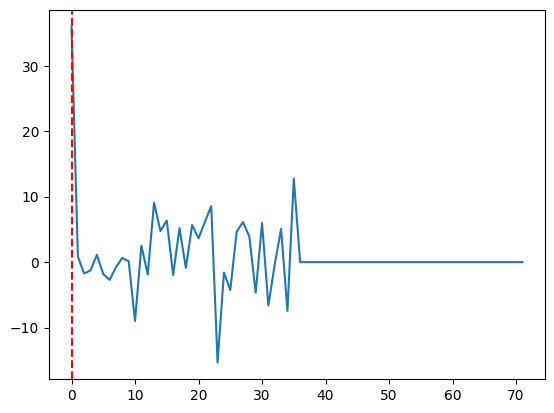

In [43]:
plt.plot(correlation_result)
plt.axvline(tau0, color='r', linestyle='--')

# add channel to the signal

In [58]:
fc = 10e3
x, h = add_channel_impulse_response(frame, fc, fs=fs, distances=np.array([10.0, 20.0]))

# add gaussian noise
snr = 20
x = add_gaussian_noise(x, snr)

In [59]:
correlation_result_after_channel = np.zeros_like(frame, dtype=np.complex64)

for i in range(0, len(frame) - frame_size):
    #correlation_result[i] = np.sum(frame[i:][:frame_size] * np.conjugate(zc_time), axis=1)
    # correlation at index i is the scalar product of the frame and the known synchronization frame, due to complex synchronization frame we need to use the conjugate
    correlation_result_after_channel[i] = np.dot(x[i:][:frame_size], np.conjugate(known_sync_frame))

tau0_after_channel = np.argmax(np.abs(correlation_result_after_channel))

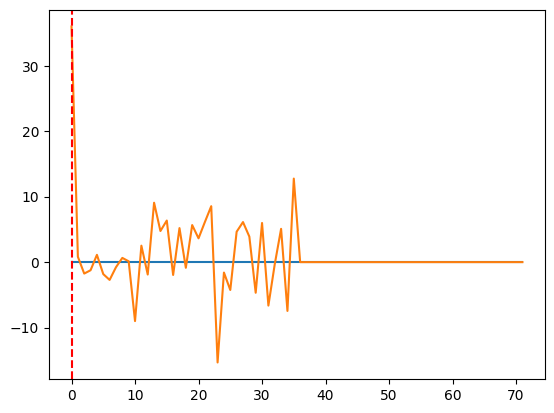

In [60]:
plt.plot(correlation_result_after_channel)
plt.plot(correlation_result)
plt.axvline(tau0_after_channel, color='r', linestyle='--')

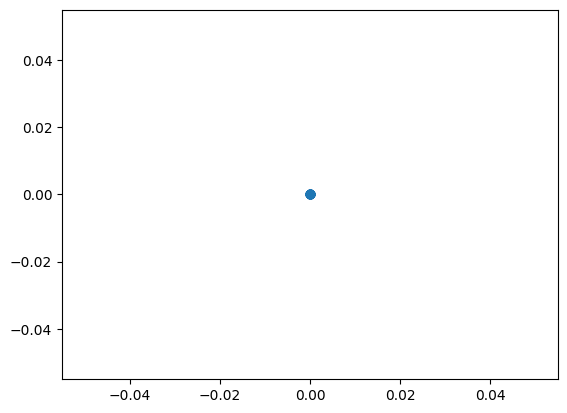

In [61]:
plt.scatter(np.real(x[frame_size]), np.imag(x))

In [62]:
h = x[:frame_size] / known_sync_frame
print(len(h))

print(len(x[frame_size:]))

36
36


/var/folders/89/fxr0x5lx46z0k6v48n7hxp6c0000gn/T/ipykernel_40440/2070584171.py:1: RuntimeWarning: invalid value encountered in divide
  x_hat_data = x[frame_size:][:frame_size] / h


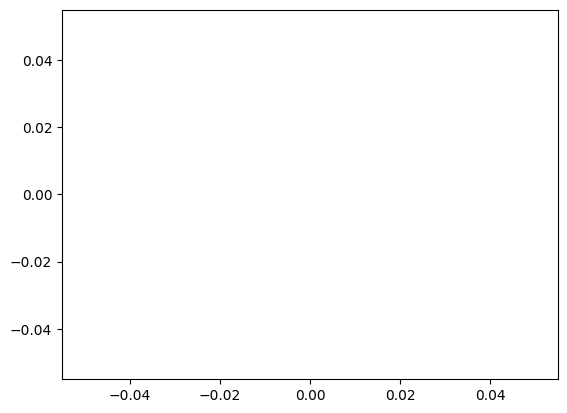

In [63]:
x_hat_data = x[frame_size:][:frame_size] / h
plt.scatter(np.real(x_hat_data), np.imag(x_hat_data))